In [1]:
# load data/cleaned_data/merged_df.parquet and put it into variable merged_df
import pandas as pd

merged_df = pd.read_parquet('data/cleaned_data/merged_df.parquet')

# check if merged_df has nan values
print(merged_df.isna().sum())
merged_df

timestamp        0
precipitation    0
percentage       0
dtype: int64


,timestamp,precipitation,percentage
0,2019-01-01 00:00:00,0.0,7.895
1,2019-01-01 00:05:00,0.0,7.895
2,2019-01-01 00:10:00,0.0,7.895
3,2019-01-01 00:15:00,0.0,7.895
4,2019-01-01 00:20:00,0.0,7.895
...,...,...,...
507883,2023-11-10 00:40:00,0.0,0.814
507884,2023-11-10 00:45:00,0.0,1.106
507885,2023-11-10 00:50:00,0.0,1.399
507886,2023-11-10 00:55:00,0.0,1.692


In [2]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import optuna
import matplotlib.pyplot as plt
import time
import pickle

In [3]:
# convert datimetime to seperate features
import datetime as dt

def convert_timestamp_to_numerical(dataset):
    dataset = dataset.copy()
    dataset['day'] = dataset['timestamp'].dt.day
    dataset['month'] = dataset['timestamp'].dt.month
    # dataset['year'] = dataset['timestamp'].dt.year
    dataset['dayofweek'] = dataset['timestamp'].dt.dayofweek
    dataset['hour'] = dataset['timestamp'].dt.hour
    # dataset['date'] = pd.to_datetime(dataset['timestamp'])
    # dataset['date'] = dataset['date'].map(dt.datetime.toordinal)
    # dataset['minute'] = dataset['timestamp'].dt.minute

    # in dataset, timestamp is the first column. put day, month, dayofweek, hour behind timestamp
    cols = dataset.columns.tolist()
    cols = cols[0:1] + cols[-4:] + cols[1:-4]
    dataset = dataset[cols]
    
    return dataset

In [4]:
start_timestamp_for_testing = pd.to_datetime('2023-03-06 08:00:00')
end_timestamp_for_testing = pd.to_datetime('2023-03-20 08:00:00')
# start_timestamp_for_testing = pd.to_datetime('2023-03-01 08:00:00')
# end_timestamp_for_testing = pd.to_datetime('2023-03-31 08:00:00')
# start_timestamp_for_testing = pd.to_datetime('2023-10-01 08:00:00')
# end_timestamp_for_testing = pd.to_datetime('2023-10-31 08:00:00')

def get_datasets_and_scaler(merged_df, features):
   #  Define the features and target variables to be used
   X = merged_df[features]
   y = merged_df['percentage_current']

   # scale the features
   scaler = StandardScaler()
   scaler.fit(X)
   
   # for testing specific dates
   X_test_specific = merged_df[(merged_df['timestamp'] >= start_timestamp_for_testing) & (merged_df['timestamp'] <= end_timestamp_for_testing)][features]
   X_test_specific = scaler.transform(X_test_specific)
   y_test_specific = merged_df[(merged_df['timestamp'] >= start_timestamp_for_testing) & (merged_df['timestamp'] <= end_timestamp_for_testing)]['percentage_current']
   
   X = scaler.transform(X)

   # Create the training and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41, shuffle=True)

   return X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific

In [5]:
def test_model(model, X_test, y_test, predictions):
    # Calculate the accuracy of the model
    accuracy = model.score(X_test, y_test)
    accuracy = round(accuracy * 100, 2)
    print(f"Accuracy: {accuracy}%")

    # Calculate the mean squared error of the model
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean squared error: {mse}")

    # Calculate the R-Squared score of the model
    print('Variance (R²) score: %.2f' % r2_score(y_test, predictions))

def save_to_pickle_file(file, filename):
    pickle.dump(file, open(filename, 'wb'))

def plot_predicted_vs_actual(y_test, predictions):
    # Plot the predictions against the actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual percentage')
    plt.ylabel('Predicted percentage')
    plt.title('Predicted percentage vs. Actual percentage')
    plt.show()

def print_time_taken(start_time, end_time):
    print(f"Time taken: {time.strftime('%H:%M:%S', time.gmtime(end_time - start_time))}")

In [6]:
train_model = True
calibrate_lag_features = False

linear_model = False
ridge_model = False
lasso_model = False
elastic_net_model = True
polynomial_model = False
random_forest_model = False
sarimix_model = False

# features = ['percentage_previous_1', 'percentage_previous_2', 'percentage_previous_3']
date_features = ['day', 'month', 'dayofweek', 'hour']
rainfall_features = ['rainfall_current', 'rainfall_previous_2_hours']
rainfall_previous_features = ['rainfall_previous_1', 'rainfall_previous_2', 'rainfall_previous_3', 'rainfall_previous_4', 'rainfall_previous_5', 'rainfall_previous_6'] 
percentage_previous_features = ['percentage_previous_1', 'percentage_previous_2', 'percentage_previous_3', 'percentage_previous_4', 'percentage_previous_5', 'percentage_previous_6']
percentage_difference_features = ['percentage_difference_1', 'percentage_difference_2', 'percentage_difference_3', 'percentage_difference_4', 'percentage_difference_5', 'percentage_difference_6', 'percentage_difference_7', 'percentage_difference_8', 'percentage_difference_9', 'percentage_difference_10', 'percentage_difference_11', 'percentage_difference_12']
# put the values in above arrays in one array

if(calibrate_lag_features):
    features = date_features + rainfall_features
else:
    features = date_features + rainfall_features + percentage_previous_features

features

['day',
 'month',
 'dayofweek',
 'hour',
 'rainfall_current',
 'rainfall_previous_2_hours',
 'percentage_previous_1',
 'percentage_previous_2',
 'percentage_previous_3',
 'percentage_previous_4',
 'percentage_previous_5',
 'percentage_previous_6']

In [7]:
# adjust columns

# rename columns
merged_df.rename(columns={'precipitation': 'rainfall_current'}, inplace=True)
merged_df.rename(columns={'percentage': 'percentage_current'}, inplace=True)

if(not calibrate_lag_features):
    # sum up the rainfall_current of the previous 24 records and put it into a new column rainfall_previous_24
    merged_df['rainfall_previous_2_hours'] = merged_df['rainfall_current'].rolling(25).sum() - merged_df['rainfall_current']
    merged_df['rainfall_previous_2_hours'].fillna(0, inplace=True)

    # the percentage of the previous 6 records in new columns
    for shift_rate in range(1, 7):
        merged_df[f'percentage_previous_{shift_rate}'] = merged_df['percentage_current'].shift(shift_rate)
        merged_df[f'percentage_previous_{shift_rate}'].fillna(0, inplace=True)

    # rainfall_lag_start = 12
    # # now shift rainfall_current an use a for loop to create rainfall_previous_1 to rainfall_previous_6
    # for shift_rate in range(1, 7):
    #     merged_df[f'rainfall_previous_{shift_rate}'] = merged_df['rainfall_current'].shift(shift_rate + rainfall_lag_start)
    #     merged_df[f'rainfall_previous_{shift_rate}'].fillna(0, inplace=True)
            
    # # the difference between the current percentage and the previous 6 percentage in new columns
    # for shift_rate in range(1, 7):
    #     merged_df[f'percentage_difference_{shift_rate}'] = merged_df['percentage_current'].shift(shift_rate) - merged_df['percentage_current'].shift(shift_rate + 1)
    #     merged_df[f'percentage_difference_{shift_rate}'].fillna(0, inplace=True)


print('Are there null values?', merged_df.isnull().values.any())

merged_df = convert_timestamp_to_numerical(merged_df)

print(merged_df.dtypes)
# merged_df

Are there null values? False
timestamp                    datetime64[ns]
day                                   int32
month                                 int32
dayofweek                             int32
hour                                  int32
rainfall_current                    float64
percentage_current                  float64
rainfall_previous_2_hours           float64
percentage_previous_1               float64
percentage_previous_2               float64
percentage_previous_3               float64
percentage_previous_4               float64
percentage_previous_5               float64
percentage_previous_6               float64
dtype: object


In [8]:
if(not calibrate_lag_features):
    X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific = get_datasets_and_scaler(merged_df, features)

    if train_model:
        # save scaler to folder models\linear_regression, with a timestamp in the name
        filename = 'scalers/scaler_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.pkl'
        pickle.dump(scaler, open(filename, 'wb'))

        def scale_features(features):
            return scaler.transform(features)

## Lag features tuning

In [9]:
if calibrate_lag_features:
    # show minimal output
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    rainfall_cumulative_calibration = True
    percentage_previous_calibration = False

    if rainfall_cumulative_calibration and not percentage_previous_calibration:
        print("Percentage previous filled")
        for shift_rate in range(1, 7):
            merged_df[f'percentage_previous_{shift_rate}'] = merged_df['percentage_current'].shift(shift_rate)
            merged_df[f'percentage_previous_{shift_rate}'].fillna(0, inplace=True)
        
        features = features + percentage_previous_features
        
    if percentage_previous_calibration and not rainfall_cumulative_calibration:
        print("Rainfall cumulative filled")
        merged_df['rainfall_previous_2_hours'] = merged_df['rainfall_current'].rolling(25).sum() - merged_df['rainfall_current']
        merged_df['rainfall_previous_2_hours'].fillna(0, inplace=True)

    print("features:", features)

    def objective(trial):
        # Rainfall cumulative tuning
        if rainfall_cumulative_calibration:
            shift_rainfall_cumulative = None
            roll_rainfall_cumulative = None

            # Everything in try block, suggestion can result as None and throw error
            try:     
                # Suggest hyperparameters
                shift_rainfall_cumulative = trial.suggest_int('shift_rainfall_param', 0, 60)
                roll_rainfall_cumulative = trial.suggest_int('roll_rainfall_param', 2, 60)
            except Exception as e_1:
                print(f"Exception: {e_1}")
                if shift_rainfall_cumulative is None:
                    print('-> shift is None')
                    shift_rainfall_cumulative = 0
                    try: 
                        roll_rainfall_cumulative = trial.suggest_int('roll_rainfall_param', 2, 60)
                    except Exception as e_2:
                        print(f"Exception: {e_2}")
                        if roll_rainfall_cumulative is None:
                            print('-> shift and roll are None')
                            roll_rainfall_cumulative = 2
                
                if roll_rainfall_cumulative is None:
                    print('-> roll is None')
                    roll_rainfall_cumulative = 2
        
            # Apply suggested params to rainfall cumulative
            start_record = merged_df['rainfall_current'].shift(shift_rainfall_cumulative)
            
            if start_record.isnull().values.any():
                merged_df['rainfall_previous_2_hours'] = 0
            else:
                rollback_sum = start_record.rolling(roll_rainfall_cumulative).sum().fillna(0)
                merged_df['rainfall_previous_2_hours'] = rollback_sum - start_record
        
            merged_df['rainfall_previous_2_hours'].fillna(0, inplace=True)
            
            X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific = get_datasets_and_scaler(merged_df, features)

        # Percentage previous tuning
        if percentage_previous_calibration:
            percentage_previous_features = []
            shift_percentage_previous = trial.suggest_int('shift_percentage_param', 1, 60)
            roll_percentage_previous = trial.suggest_int('roll_percentage_param', 1, 60)
            # print(f"shift_percentage_previous: {shift_percentage_previous} | roll_percentage_previous: {roll_percentage_previous}")

            try:     
                # Suggest hyperparameters
                shift_percentage_previous = trial.suggest_int('shift_percentage_param', 1, 60)
                roll_percentage_previous = trial.suggest_int('roll_percentage_param', 1, 60)
            except Exception as e_1:
                print(f"Exception: {e_1}")
                if shift_percentage_previous is None:
                    print('-> shift percentage is None')
                    shift_percentage_previous = 1
                    try: 
                        roll_percentage_previous = trial.suggest_int('roll_percentage_param', 1, 60)
                    except Exception as e_2:
                        print(f"Exception: {e_2}")
                        if roll_percentage_previous is None:
                            print('-> shift and roll percentage are None')
                            roll_percentage_previous = 1
                
                if roll_percentage_previous is None:
                    print('-> roll is None')
                    roll_percentage_previous = 1
                    
            # the percentage of the previous 6 records in new columns
            for roll in range(1, roll_percentage_previous + 1):
                previous_value = merged_df['percentage_current'].shift(shift_percentage_previous + roll - 1)

                if not previous_value.isnull().values.any():
                    merged_df[f'percentage_previous_{roll}'] = previous_value
                else:
                    merged_df[f'percentage_previous_{roll}'] = 0

                merged_df[f'percentage_previous_{roll}'].fillna(0, inplace=True)
                percentage_previous_features.append(f'percentage_previous_{roll}')

            X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific = get_datasets_and_scaler(merged_df, features + percentage_previous_features)

        model = LinearRegression()
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        accuracy = model.score(X_test, y_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        # predictions = model.predict(X_test_specific)

        # accuracy = model.score(X_test_specific, y_test)
        # mse = mean_squared_error(y_test, predictions)
        # r2 = r2_score(y_test, predictions)

        # check if accuracy, mse or r2 is None, metric may result as None and will throw error
        if accuracy is None or mse is None or r2 is None:
            print('--------------------------------------------------------------------', accuracy, mse, r2)
            if accuracy is None:
                accuracy = 0
            if mse is None:
                mse = 9999999
            if r2 is None:
                r2 = 0

        # return accuracy
        return accuracy, mse, r2 # The objective to be maximized

    # Initialize Optuna study
    # study = optuna.create_study(direction="maximize")
    study = optuna.create_study(directions=["maximize", "minimize", "maximize"])

    # track time in hours and minutes
    start_time = time.time()

    # Optimize the study, the objective function is called here
    study.optimize(objective, n_trials=20000, n_jobs=120)  # Adjust n_trials for your needs

    print_time_taken(start_time, time.time())

    # Print the best parameters
    for best_trial in study.best_trials:
        print(f"Best values: {best_trial.values} | best params: {best_trial.params}")

## -------------------- START MODEL TRAINING --------------------

## TPOT

In [10]:
# # Use TPOT to find the best model
# from tpot import TPOTRegressor

# # Use TPOT to find the best model
# tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=41)

# # track time in hours and minutes
# start_time = time.time()

# tpot.fit(X_train, y_train)

# # Print the time elapsed
# print_time_taken(start_time, time.time())

# print(tpot.score(X_test, y_test))
# tpot.export('tpot_exported_pipeline.py')

# # Make predictions on the test set
# predictions = tpot.predict(X_test)

# # Calculate the accuracy of the model
# test_model(tpot, X_test, y_test, predictions)

# # Plot the predictions against the actual values
# plot_predicted_vs_actual(y_test, predictions)

In [11]:
# # TPOT result
# from sklearn.svm import LinearSVR
# from sklearn.tree import DecisionTreeRegressor
# from tpot.builtins import StackingEstimator
# from tpot.export_utils import set_param_recursive


# # Average CV score on the training set was: -0.6345471715614988
# exported_pipeline = make_pipeline(
#     StackingEstimator(estimator=LinearSVR(C=20.0, dual=True, epsilon=0.01, loss="epsilon_insensitive", tol=0.01)),
#     DecisionTreeRegressor(max_depth=8, min_samples_leaf=16, min_samples_split=12)
# )
# # Fix random state for all the steps in exported pipeline
# set_param_recursive(exported_pipeline.steps, 'random_state', 41)

# # track time in hours and minutes
# start_time = time.time()

# exported_pipeline.fit(X_train, y_train)

# # Print the time elapsed
# print_time_taken(start_time, time.time())

# predictions = exported_pipeline.predict(X_test)

# test_model(exported_pipeline, X_test, y_test, predictions)

## Linear models

elastic net model is training...
{'alpha': 0.0001, 'l1_ratio': 0.9}
Time taken: 01:23:06
Accuracy: 99.76%
Mean squared error: 0.9796627160031509
Variance (R²) score: 1.00


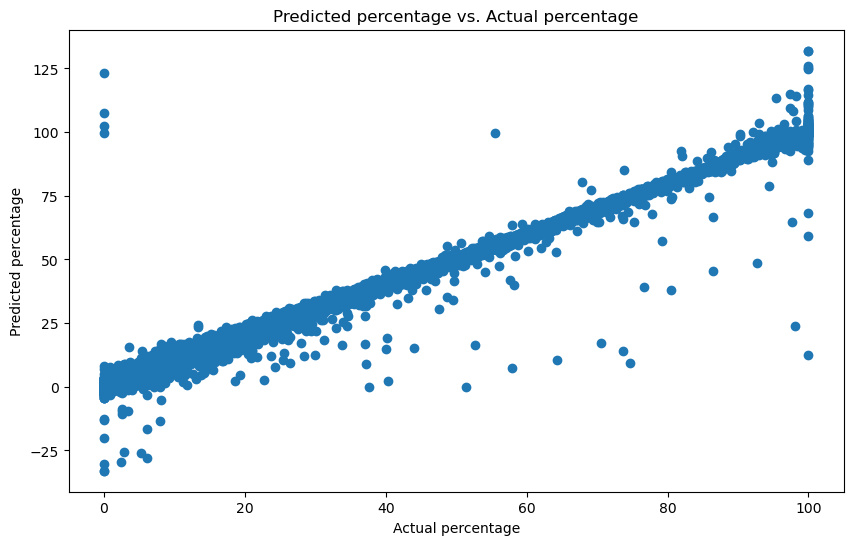

In [12]:
# linear_model, ridge_model, lasso_model, elastic_net_model
if(train_model and (linear_model or ridge_model or lasso_model or elastic_net_model)):
    model_type = None

    # track time in hours and minutes
    start_time = time.time()

    if(linear_model):
        # Create the linear regression model and train/fit it
        print('linear model is training...')
        model = LinearRegression()
        model.fit(X_train, y_train)
        model_type = 'linear_regression'
    elif(ridge_model):
        # Create the ridge regression model and train/fit it, use GridSearchCV to find the best alpha
        print('ridge model is training...')
        model = Ridge()
        parameters = {'alpha': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]}
        ridge_regressor = GridSearchCV(model, parameters, n_jobs=3)
        ridge_regressor.fit(X_train, y_train)
        print(ridge_regressor.best_params_)
        model = ridge_regressor.best_estimator_
        model_type = 'ridge_regression'
    elif(lasso_model):
        # Create the lasso regression model and train/fit it, use GridSearchCV to find the best alpha
        print('lasso model is training...')
        model = Lasso(max_iter=5000)
        parameters = {'alpha': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]}
        lasso_regressor = GridSearchCV(model, parameters, n_jobs=3)
        lasso_regressor.fit(X_train, y_train)
        print(lasso_regressor.best_params_)
        model = lasso_regressor.best_estimator_
        model_type = 'lasso_regression'
    elif(elastic_net_model):
        # Create the elastic net regression model and train/fit it, use GridSearchCV to find the best alpha and l1_ratio
        print('elastic net model is training...')
        model = ElasticNet(max_iter=5000)
        parameters = {'alpha': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]}
        elastic_net_regressor = GridSearchCV(model, parameters, n_jobs=3)
        elastic_net_regressor.fit(X_train, y_train)
        print(elastic_net_regressor.best_params_)
        model = elastic_net_regressor.best_estimator_
        model_type = 'elastic_net_regression'
    
    
    # Print the time elapsed
    print_time_taken(start_time, time.time())

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Test the model
    test_model(model, X_test, y_test, predictions)

    # Plot the predictions against the actual values
    plot_predicted_vs_actual(y_test, predictions)

    # save model to folder models\linear_regression with a timestamp in the name
    filename = f'models/linear_regression/model_{model_type}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
    save_to_pickle_file(model, filename)

In [13]:
# Polynomial linear regression
if(train_model and polynomial_model):   
    polynomial_degrees = [2, 3, 4]
    accuracy_score_highest = 0
    best_predictions = None
    best_model = None

    # track time in hours and minutes
    start_time = time.time()

    for degree in polynomial_degrees:
        print("Polynomial degree: ", degree)

        # Create the linear regression model and train/fit it
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X_train, y_train)

        # Make predictions on the test set
        predictions = model.predict(X_test)

        # Calculate the metrics of the model
        accuracy_initial = model.score(X_test, y_test)
        accuracy = round(accuracy_initial * 100, 2)
        print(f"Accuracy: {accuracy}%")

        # Calculate the mean squared error of the model
        mse = mean_squared_error(y_test, predictions)
        print(f"Mean squared error: {mse}")

        # Calculate the R-Squared score of the model
        print('Variance (R²) score: %.2f' % r2_score(y_test, predictions))
        
        # save model to folder models\linear_regression with a timestamp in the name
        filename = f'models/linear_regression/model_poly_{degree}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
        pickle.dump(model, open(filename, 'wb'))

        if (accuracy_initial > accuracy_score_highest):
            accuracy_score_highest = accuracy_initial
            best_predictions = predictions
            best_model = model

    # Print the time elapsed
    print_time_taken(start_time, time.time())

    model = best_model

    # Plot the predictions against the actual values
    plot_predicted_vs_actual(y_test, best_predictions)

## Random forest

In [14]:
# # random forest with for-loop
# if(train_model and random_forest_model):
#     accuracy_score_highest = 0
#     best_predictions = None
#     best_model = None
    
#     for n_estimators in range(1, 11):
#         for max_depth in range(1, 51):
#     # for n_estimators in [38, 39, 40, 49, 50, 51]:
#     # for max_depth in [9, 10, 11, 30, 31, 32]:
#             # print(f"---- n_estimators: {n_estimators}")
#             print(f"---- n_estimators: {n_estimators} - max_depth: {max_depth}")
            
#             # Create the random forest model and train/fit it
#             # model = RandomForestRegressor(n_estimators=n_estimators, random_state=41, n_jobs=-1)
#             model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth , random_state=41, n_jobs=-1)

#             start = time.time()
#             model.fit(X_train, y_train)
#             print_time_taken(start, time.time())
            
#             # Make predictions on the test set
#             predictions = model.predict(X_test)

#             accuracy = model.score(X_test, y_test)
#             accuracy_score = round(accuracy * 100, 2)
#             mean_squared_error_test = mean_squared_error(y_test, predictions)
#             r2_score_test = r2_score(y_test, predictions)

#             # # Make predictions on the test set
#             # predictions = model.predict(X_test_specific)

#             # accuracy = model.score(X_test_specific, y_test_specific)
#             # accuracy_score = round(accuracy * 100, 2)
#             # mean_squared_error_test = mean_squared_error(y_test_specific, predictions)
#             # r2_score_test = r2_score(y_test_specific, predictions)

#             # filename = f'models/random_forest/model_rf_{n_estimators}.pkl'
#             filename = f'models/random_forest/model_rf_{n_estimators}_{max_depth}.pkl'
#             save_to_pickle_file(model, filename)

#             if (accuracy > accuracy_score_highest):
#                 accuracy_score_highest = accuracy
                
#                 # get accuracy of the model
#                 print("Accuracy of the model: ", accuracy_score, "%")

#                 # test the model
#                 print("Mean squared error: %.2f" % mean_squared_error_test)
#                 print('Variance (R²) score: %.2f' % r2_score_test)

#                 # # remove evertyhing in folder models\random_forest that starts with model_
#                 # import os, glob
#                 # files = glob.glob('models/random_forest/model_*')
#                 # for f in files:
#                 #     os.remove(f)

#                 # save model to folder models\random_forest with a timestamp in the name
#                 # filename = f'models/random_forest/model_rf_{n_estimators}.pkl'
#                 # filename = f'models/random_forest/model_rf_{n_estimators}_{max_depth}.pkl'
#                 save_to_pickle_file(model, filename)

#                 best_predictions = predictions
#                 best_model = model

#     model = best_model

#     # Plot the predictions against the actual values
#     # plot_predicted_vs_actual(y_test, predictions)
#     plot_predicted_vs_actual(y_test, predictions)

In [15]:
# random forest with GridSearchCV
if train_model and random_forest_model:
    best_predictions = None
    best_model = None

    # # Define the parameter grid for GridSearchCV
    # param_grid = {
    #     'n_estimators': range(1, 101)
    # }
       
    param_grid = {
        'n_estimators': range(1, 51),
        'max_depth': range(1, 51)
    }

    # Create the Random Forest model
    model = RandomForestRegressor(random_state=41, n_jobs=-1)

    # Perform Grid Search to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=3)

    # track time in hours and minutes
    start_time = time.time()

    grid_search.fit(X_train, y_train)

    # Print the time elapsed
    print_time_taken(start_time, time.time())

    # Get the best model and its parameters
    model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set using the best model
    predictions = model.predict(X_test)

    # Evaluate the best model
    accuracy_score = model.score(X_test, y_test) * 100
    mean_squared_error_test = mean_squared_error(y_test, predictions)
    r2_score_test = r2_score(y_test, predictions)

    print("Best parameters:", best_params)
    print("Accuracy of the best model: {:.2f}%".format(accuracy_score))
    print("Mean squared error: {:.2f}".format(mean_squared_error_test))
    print("Variance (R²) score: {:.2f}".format(r2_score_test))

    # Save the model

    filename = 'models/random_forest/best_model_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.pkl'
    save_to_pickle_file(model, filename)

    # Plot the predictions against the actual values
    plot_predicted_vs_actual(y_test, predictions)

In [16]:
# # random forest with optuna
# if train_model and random_forest_model:
#     # show minimal output
#     optuna.logging.set_verbosity(optuna.logging.WARNING)

#     # random forest with optuna
#     def objective(trial):
#         # Suggest hyperparameters
#         n_estimators = trial.suggest_int('n_estimators', 1, 50)
#         max_depth = trial.suggest_int('max_depth', 1, 50)
        
#         # Create and train the Random Forest model
#         model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=41, n_jobs=-1)
#         model.fit(X_train, y_train)
        
#         # Make predictions and evaluate the model
#         predictions = model.predict(X_test)
        
#         accuracy = model.score(X_test, y_test)
#         mse = mean_squared_error(y_test, predictions)
#         r2 = r2_score(y_test, predictions)
        
#         # return accuracy
#         return accuracy, mse, r2
    
#     # Initialize Optuna study
#     study = optuna.create_study(directions=["maximize", "minimize", "maximize"])
    
#     # Track time
#     start_time = time.time()
    
#     # Optimize the study
#     study.optimize(objective, n_trials=10000, n_jobs=-1)  # Adjust n_trials for your needs
    
#     # Print time taken
#     print_time_taken(start_time, time.time())
    
#     # Print the best parameters
#     for best_trial in study.best_trials:
#         print(f"Best values: {best_trial.values} | best params: {best_trial.params}")

## -------------------- END MODEL TRAINING --------------------

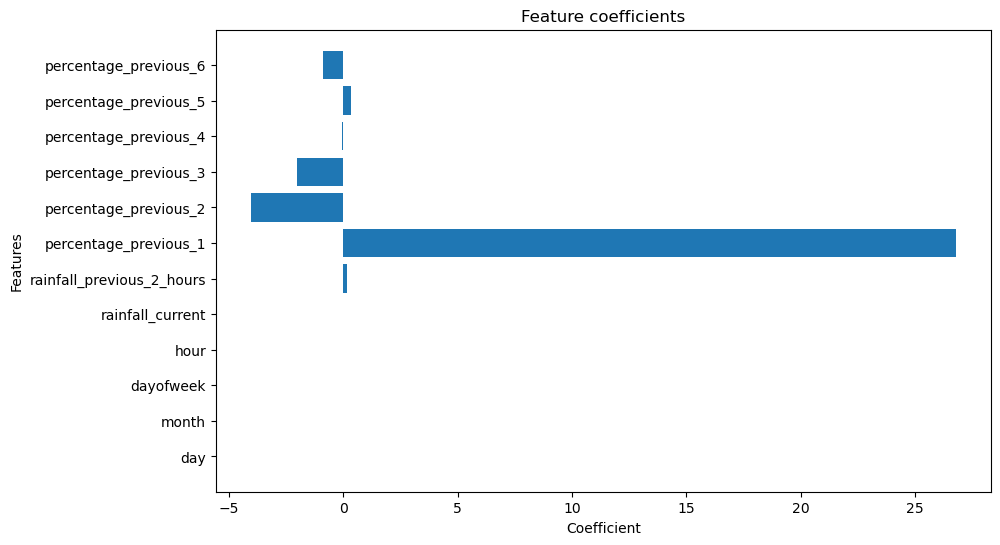

In [17]:
# plot the prediction power of the features that model is using, in a horizontal bar chart
if(train_model and not random_forest_model and not polynomial_model):
    # Plot the prediction power of the features that model is using, in a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(features, model.coef_)
    plt.xlabel('Coefficient')
    plt.ylabel('Features')
    plt.title('Feature coefficients')
    plt.show()
elif(train_model and random_forest_model):
    # Plot the prediction power of the features that the random forest regression model is using, in a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(features, model.feature_importances_)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.title('Feature importance')
    plt.show()
elif(train_model and polynomial_model):
    # Plot the prediction power of the features that the polynomial regression model is using, in a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(features, model.named_steps['linearregression'].coef_)
    plt.xlabel('Coefficient')
    plt.ylabel('Features')
    plt.title('Feature coefficients')
    plt.show()

In [18]:
# # fetch test data for prediction
# # give me a record in merged_df where percentage current is 100, give me the first one
# data_100 = merged_df[merged_df['percentage_current'] == 100].iloc[0]

# # give me a record in merged_df where percentage current is between 45 and 55, give me the first one
# # merged_df[(merged_df['percentage_current'] >= 45) & (merged_df['percentage_current'] <= 55)].iloc[0]

# print(data_100)
# # data_100 = data_100.reindex(['date'] + list(data_100.index[:-1]))
# # data_100 = data_100.drop('timestamp')
# # data_100 = data_100.drop('percentage_current')

In [19]:
# # test prediction
# if(train_model):
#     # prediction_1 = model.predict(scale_features([[6, 2, 2024, 1, 8, 0, 3.4, 0]]))
#     # prediction_2 = model.predict(scale_features([[6, 2, 2024, 1, 8, 0, 3.4, 10]]))
#     # prediction_3 = model.predict(scale_features([[6, 2, 2024, 1, 8, 0, 3.4, 0]]))
#     # 'day', 'month', 'dayofweek', 'hour', 'rainfall_current', 'rainfall_previous_2_hours', 'percentage_previous_1', 'percentage_previous_2', 'percentage_previous_3',
#     # 'percentage_previous_4', 'percentage_previous_5', 'percentage_previous_6'
#     # rainfall_previous_array = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
#     date_features_array = [28, 1, 0, 2]
#     rainfall_features = [0.139999, 2.299995]
#     rainfall_previous_feature_array = [0, 0, 0, 0, 0, 0]
#     percentage_previous_feature_array = [96.4912, 95.614, 95.614, 95.614, 94.737, 93.86]
#     percentage_difference_feature_array = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#     input = pd.DataFrame([date_features_array + rainfall_features + percentage_previous_feature_array + rainfall_previous_feature_array], columns=features)
#     # input = pd.DataFrame([data_100], columns=features)

#     prediction_4 = model.predict(scale_features(input))

#     # print(prediction_1)
#     # print(prediction_2)
#     # print(prediction_3)
#     print(prediction_4)

In [20]:
# weather data shift 6 months later
# set every timestamp in merged_df to 6 months later, and put this in a new dataframe
weather_data_6_months_later = merged_df.copy()
weather_data_6_months_later['timestamp'] = weather_data_6_months_later['timestamp'] + pd.DateOffset(months=6)
# only give me timestamp and rainfall_current
weather_data_6_months_later = weather_data_6_months_later[['timestamp', 'rainfall_current', 'rainfall_previous_2_hours']]
weather_data_6_months_later

# # export weather_data_6_months_later to xlsx
# weather_data_6_months_later.to_excel('data/cleaned_data/weather_data_6_months_later.xlsx')

,timestamp,rainfall_current,rainfall_previous_2_hours
0,2019-07-01 00:00:00,0.0,0.0
1,2019-07-01 00:05:00,0.0,0.0
2,2019-07-01 00:10:00,0.0,0.0
3,2019-07-01 00:15:00,0.0,0.0
4,2019-07-01 00:20:00,0.0,0.0
...,...,...,...
507883,2024-05-10 00:40:00,0.0,0.0
507884,2024-05-10 00:45:00,0.0,0.0
507885,2024-05-10 00:50:00,0.0,0.0
507886,2024-05-10 00:55:00,0.0,0.0


In [21]:
def format_prediction(prediction):
    if(prediction < 0):
        return  0
    elif(prediction > 100):
        return  100
    else:
        return prediction

In [22]:
training_verbose = False
predictions_to_excel = False

In [23]:
def data_to_input(dataset, percentages_previous, start_timestamp):
# def data_to_input(dataset, percentages_previous, percentage_difference, start_timestamp):
    # print('---------------- TIMESTAMP ----------------', start_timestamp)
    data_specific_timestamp = dataset[dataset['timestamp'] == start_timestamp]
    data_specific_timestamp = convert_timestamp_to_numerical(data_specific_timestamp)
    
    # print(data_specific_timestamp)
    day = data_specific_timestamp['day'].values[0]
    month = data_specific_timestamp['month'].values[0]
    dayofweek = data_specific_timestamp['dayofweek'].values[0]
    hour = data_specific_timestamp['hour'].values[0]
    # date = data_specific_timestamp['date'].values[0]
    date_features = [day, month, dayofweek, hour]

    rainfall_current = data_specific_timestamp["rainfall_current"].values[0]
    rainfall_previous_2_hours = data_specific_timestamp['rainfall_previous_2_hours'].values[0]
   
    percentage_previous_1 = percentages_previous[0]
    percentage_previous_2 = percentages_previous[1]
    percentage_previous_3 = percentages_previous[2]
    percentage_previous_4 = percentages_previous[3]
    percentage_previous_5 = percentages_previous[4]
    percentage_previous_6 = percentages_previous[5]
    percentage_previous_array = [percentage_previous_1, percentage_previous_2, percentage_previous_3, percentage_previous_4, percentage_previous_5, percentage_previous_6]

    # percentage_difference_1 = percentage_difference[0]
    # percentage_difference_2 = percentage_difference[1]
    # percentage_difference_3 = percentage_difference[2]
    # percentage_difference_4 = percentage_difference[3]
    # percentage_difference_5 = percentage_difference[4]
    # percentage_difference_6 = percentage_difference[5]
    # percentage_difference_7 = percentage_difference[6]
    # percentage_difference_8 = percentage_difference[7]
    # percentage_difference_9 = percentage_difference[8]
    # percentage_difference_10 = percentage_difference[9]
    # percentage_difference_11 = percentage_difference[10]
    # percentage_difference_12 = percentage_difference[11]
    # percentage_differences_array = [percentage_difference_1, percentage_difference_2, percentage_difference_3, percentage_difference_4, percentage_difference_5, percentage_difference_6, percentage_difference_7, percentage_difference_8, percentage_difference_9, percentage_difference_10, percentage_difference_11, percentage_difference_12]
 
    input_df = pd.DataFrame([date_features + [rainfall_current, rainfall_previous_2_hours] + percentage_previous_array], columns=features)

    if training_verbose:
        print('----INPUT_DF----\n', input_df.values)
    
    return input_df

In [24]:
def create_initial_predictions_df(start_timestamp, weather_data, model, scaler, polygon_id, range_previous_percentage):
    initial_timestamps_minus = []
    initial_previous_percentage = [0] * range_previous_percentage
    initial_differences_percentage = [0] * 12
    pre_predictions_df = None
    
    for i in range(1, range_previous_percentage+1):
        start_timestamp_minus = start_timestamp - pd.Timedelta(minutes=i*5)
        initial_timestamps_minus.append(start_timestamp_minus)
    
    # turn around initial_timestamps_minus
    initial_timestamps_minus.reverse()
    
    if training_verbose:
        print('------ PRE-PREDICTION DATES-------\n', initial_timestamps_minus)

    for start_timestamp_minus in initial_timestamps_minus:
        if training_verbose:
            print('------ CURRENT PRE-PREDICTION DATE:', start_timestamp_minus)
            
        weather_data_minus = convert_timestamp_to_numerical(weather_data[weather_data['timestamp'] == start_timestamp_minus])
        
        input_minus = data_to_input(weather_data_minus, initial_previous_percentage, start_timestamp_minus)
        # input_minus = data_to_input(weather_data_minus, initial_previous_percentage, initial_differences_percentage, start_timestamp_minus)
        # print('------input_minus-------', input_minus.filter(regex='percentage_previous_'))

        prediction_minus = format_prediction(model.predict(scaler.transform(input_minus))[0])

        if training_verbose:
            print('------CURRENT PRE-PREDICTION RESULT:', prediction_minus)

        # add prediction_minus to the front of initial_previous_percentage
        initial_previous_percentage.insert(0, prediction_minus)
        initial_previous_percentage.pop()

        # # add value to pre_percentage_differences and remove last value
        # initial_differences_percentage.insert(0, prediction_minus - initial_previous_percentage[1])
        # initial_differences_percentage.pop()

        # add record to pre_predictions_df
        pre_predictions_df = pd.concat([pre_predictions_df, pd.DataFrame([[start_timestamp_minus, prediction_minus, input_minus['rainfall_current'].values[0]]], columns=['timestamp', 'percentage_current', 'rainfall_current'])], ignore_index=True)

    return initial_previous_percentage, initial_differences_percentage, pre_predictions_df

def create_predictions_df(start_timestamp, end_timestamp, weather_data, model, scaler, polygon_id):
    if training_verbose:
        print('------------------------------------ PRE-PREDICTIONS ------------------------------------')   
    
    # Make the initial predictions (start_timestamp, weather_data, model, scaler, polygon_id, range_previous_percentage (per 5 minutes back))
    pre_percentage_predictions, pre_percentage_differences, pre_predictions_df = create_initial_predictions_df(start_timestamp, weather_data, model, scaler, polygon_id, 6)
    
    if training_verbose:
        print('------------------------------------ PREDICTIONS ------------------------------------')   
    
    # Create a boolean mask for the specified time range
    mask = (weather_data['timestamp'] >= start_timestamp) & (weather_data['timestamp'] <= end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    weather_data = weather_data[mask]

    # initialize predictions_df
    predictions_df = None
    # predictions_df = pd.DataFrame(columns=['timestamp', 'percentage_current', 'rainfall_current'])
    
    print('Pre-predictions:\n', pre_predictions_df)

    while(start_timestamp <= end_timestamp):
        # convert multiple data sources to one input
        input_prediction = data_to_input(weather_data, pre_percentage_predictions, start_timestamp)
        # input_prediction = data_to_input(weather_data, pre_percentage_predictions, pre_percentage_differences, start_timestamp)

        # scale and predict
        prediction = model.predict(scaler.transform(input_prediction))
        prediction = format_prediction(prediction[0])
        
        # add record to predictions_df, use concat
        predictions_df = pd.concat([predictions_df, pd.DataFrame([[start_timestamp, prediction, input_prediction['rainfall_current'].values[0]]], columns=['timestamp', 'percentage_current', 'rainfall_current'])], ignore_index=True)

        # add value to pre_predictions and remove last value
        pre_percentage_predictions.insert(0, prediction)
        pre_percentage_predictions.pop()

        # # add value to pre_percentage_differences and remove last value
        # pre_percentage_differences.insert(0, prediction - pre_percentage_predictions[1])
        # pre_percentage_differences.pop()

        # increment start_timestamp with 5 minutes
        start_timestamp = start_timestamp + pd.Timedelta(minutes=5)

    return predictions_df, pre_predictions_df

In [25]:
def plot_predictions_and_rainfall(pred_df, pre_pred_df, model_name):
    # plot the predictions in a line chart, put the percentage and rainfull_current against each other
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Rainfall (mm)')
    ax1.plot(pred_df['timestamp'], pred_df['rainfall_current'], color='blue')
    ax1.plot(pre_pred_df['timestamp'], pre_pred_df['rainfall_current'], color='blue', linestyle='dashed')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Percentage (%)')
    ax2.plot(pred_df['timestamp'], pred_df['percentage_current'], color='red')
    ax2.plot(pre_pred_df['timestamp'], pre_pred_df['percentage_current'], color='red', linestyle='dashed')
    ax2.tick_params(axis='y')

    fig.legend(['Rainfall', 'Rainfall pre', 'Percentage', 'Percentage pre'], loc='upper right')

    fig.tight_layout()

    plt.title(f'Rainfall and percentage full over time - {model_name}')
    plt.show()

In [26]:
def plot_predictions_and_actual(pred_df, pre_pred_df, model_name, actual_data):
    # plot the predictions and actual data in a line chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Percentage (%)')
    ax.plot(actual_data['timestamp'], actual_data['percentage_current'], color='blue')
    ax.plot(pred_df['timestamp'], pred_df['percentage_current'], color='red')
    ax.plot(pre_pred_df['timestamp'], pre_pred_df['percentage_current'], color='red', linestyle='dashed')

    fig.legend(['Actual data', 'Prediction', 'Prediction pre'], loc='upper right')

    fig.tight_layout()

    plt.title(f'Predicted percentage full over time - {model_name}')
    plt.show()

In [27]:
def predict_test_plot(model, scaler, model_name, start_timestamp, end_timestamp, future_weather_data, polygon_id, against_actual):
    print(f'------------------------------------ {model_name} ------------------------------------')

    # Make the predictions
    pred_df, pre_pred_df = create_predictions_df(start_timestamp, end_timestamp, future_weather_data, model, scaler, polygon_id)

    # # Test the model
    # print('\nMetrics for full test set:')
    # predictions = model.predict(X_test)
    # test_model(model, X_test, y_test, predictions)

    # Test the model on the specific test set
    print('\nMetrics for this specific prediction:')
    predictions = model.predict(X_test_specific)
    test_model(model, X_test_specific, y_test_specific, predictions)
    
    if(against_actual):
        # Plot the predictions against the actual values
        plot_predictions_and_actual(pred_df, pre_pred_df, model_name, future_weather_data)
    else:
        # Plot the predictions against the rainfall
        plot_predictions_and_rainfall(pred_df, pre_pred_df, model_name)

    if(predictions_to_excel):
        # write pred_df to excel in folder predictions, with a timestamp in the name and model name in the name (linear_regression)
        pred_df.to_excel(f'predictions/pred_df_{model_name}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.xlsx', index=False)
        pre_pred_df.to_excel(f'predictions/pre_pred_df_{model_name}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.xlsx', index=False)

[[----- NEW MODEL USED -----]]
Pre-predictions:
             timestamp  percentage_current  rainfall_current
0 2023-03-06 07:30:00            0.019984               0.0
1 2023-03-06 07:35:00            0.046457               0.0
2 2023-03-06 07:40:00            0.077532               0.0
3 2023-03-06 07:45:00            0.111402               0.0
4 2023-03-06 07:50:00            0.147337               0.0
5 2023-03-06 07:55:00            0.185306               0.0


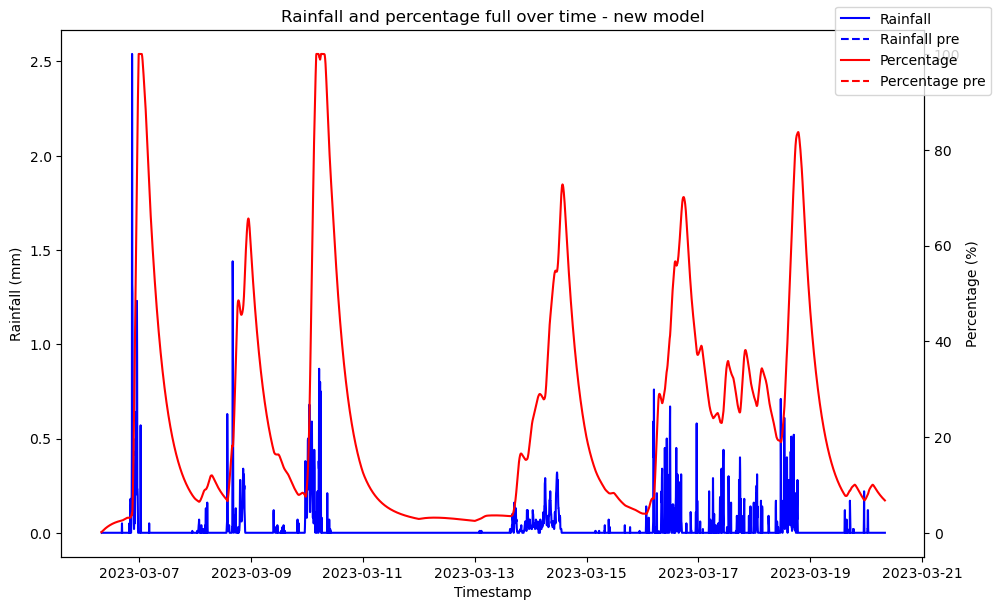

In [28]:
import glob

plot_against_actual = True

# if not train model
if not train_model:
    print('[[----- BEST MODELS ARE LOADED -----]]')
    # load all models from folder models\best_models, put them in a dictionary with the file name as key
    models = {}
    # files = glob.glob('models/best_models/model_*')
    files_linear_shuffled = glob.glob('models/best_models/fixed_data/linear_shuffled/model_*')
    # files_linear_shuffled_stf = glob.glob('models/best_models/fixed_data/linear_shuffled_stf/model_*')
    # files_randomforest_shuffled = glob.glob('models/best_models/fixed_data/random_forest_shuffled/model_*')
    # files_randomforest_shuffled_stf = glob.glob('models/best_models/fixed_data/random_forest_shuffled_stf/model_*')

    # files_linear_shuffled = glob.glob('models/best_models/old_data/linear_shuffled/model_*')
    # files_randomforest_shuffled = glob.glob('models/best_models/old_data/random_forest_shuffled/model_*')
    # files_randomforest_shuffled_stf = glob.glob('models/best_models/old_data/random_forest_shuffled_stf/model_*')


    # files_linear = glob.glob('models/best_models/linear/model_*')
    # files_randomforest = glob.glob('models/best_models/random_forest/model_*')

    # files = files_linear + files_randomforest + files_linear_shuffled + files_randomforest_shuffled
    files =  files_linear_shuffled

    # Load the scaler from folder models\best_models
    scaler_path = glob.glob('models/best_models/scaler_*')
    scaler = pickle.load(open(scaler_path[0], 'rb'))

    for f in files:
        # model name is everything after model_ and before .pkl
        model_name = f.split('model_')[1].split('.pkl')[0]
        models[model_name] = pickle.load(open(f, 'rb'))

        # # save model with the same name
        # filename = f'models/best_models/random_forest_shuffled/model_{model_name}.pkl'
        # save_to_pickle_file(models[model_name], filename)

        weather_data_for_loaded_models = None

        if(plot_against_actual):
            weather_data_for_loaded_models = merged_df[(merged_df['timestamp'] >= start_timestamp_for_testing - pd.Timedelta(minutes=30)) & (merged_df['timestamp'] <= end_timestamp_for_testing)].copy()
        else:
            weather_data_for_loaded_models = weather_data_6_months_later

        predict_test_plot(models[model_name], scaler, model_name, start_timestamp_for_testing, end_timestamp_for_testing, weather_data_for_loaded_models, 'polygon_1663', plot_against_actual)
else:
    print('[[----- NEW MODEL USED -----]]')

    pred_df, pre_pred_df = create_predictions_df(start_timestamp_for_testing, end_timestamp_for_testing, weather_data_6_months_later, model, scaler, 'polygon_1663')

    plot_predictions_and_rainfall(pred_df, pre_pred_df, 'new model')

    if(predictions_to_excel):
        # write pred_df to excel in folder predictions
        pred_df.to_excel('predictions/pred_df_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.xlsx', index=False)
        pre_pred_df.to_excel('predictions/pre_pred_df_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.xlsx', index=False)